# AGH Modelling of Physical Systems Lab 6 (2025 April 8th)
Sylwester Arabas (sylwester.arabas@agh.edu.pl) & Emma Ware (ecware@ucdavis.edu) 

**1. particle-resolved random-sampled state representation for an advection problem**

In [232]:
""" notebook code targetting 100% `nbqa pylint` score! :) """

from types import SimpleNamespace
import numpy as np
from matplotlib import pyplot as plt
import scipy
from open_atmos_jupyter_utils import show_plot

In [233]:
PARAMS_P = SimpleNamespace(
    n_part=1000,
    norm=1e10,
    dist=scipy.stats.norm(loc=250, scale=50),
)

PARAMS_X = SimpleNamespace(
    span=1000,
    n_cell=32,
)
PARAMS_X.step = PARAMS_X.span / PARAMS_X.n_cell

PARAMS_Z = SimpleNamespace(
    span=1000,
    n_cell=32,
)
PARAMS_Z.step = PARAMS_Z.span / PARAMS_Z.n_cell

RNG = np.random.default_rng(seed=44)

## Introducing another dimension
We introduce another dimension by adding cells along axis z.

To handle advection in different directions we also introduce another axis for wind speed.

In [234]:
def sample(*, params_p, params_x, params_z, rng):
    """ Samples a particle population onto a 3D grid and returns
    a collection indexed by sampling type, with values composed of `cell_x`, `cell_z`, and `mult`
    integer-valued arrays with cell IDs and multiplicities, respectively. """

    u01_x = rng.uniform(0, 1, size=params_p.n_part)
    u01_z = rng.uniform(0, 1, size=params_p.n_part)

    return {
        k: {
            'cell_x': (v['x'] / params_x.step).astype(int),
            'cell_z': (v['z'] / params_z.step).astype(int),
            'mult': np.round(v['y'] * params_p.norm).astype(int),
        }
        for k, v in
        {
            'sampling: uniform random in x and z': {
                'x': u01_x * params_x.span,
                'z': u01_z * params_z.span,
                'y': params_p.dist.pdf(u01_x * params_x.span) * params_x.span / params_p.n_part
                   + params_p.dist.pdf(u01_z * params_z.span) * params_z.span / params_p.n_part,
            },
            'sampling: constant multiplicity in x and z': {
                'x': params_p.dist.ppf(u01_x),
                'z': params_p.dist.ppf(u01_z),
                'y': np.full(shape=params_p.n_part, fill_value=1 / params_p.n_part),
            }
        }.items()
    }

PARTICLES = sample(params_p=PARAMS_P, params_x=PARAMS_X, params_z=PARAMS_Z, rng=RNG)

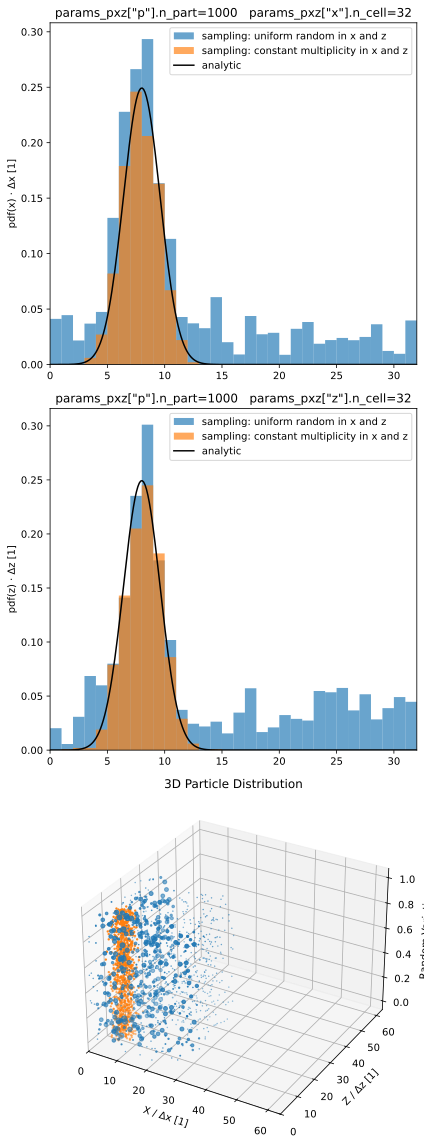

In [235]:
def plot(*, particles, params_pxz, rng, title='', shift=(0,0)):
    """ Plots the particle state as a 3D scatter plot alongside a histogram. """

    fig = plt.figure(figsize=(6, 16))
    ax_hist = fig.add_subplot(311)  # 2D histogram
    az_hist = fig.add_subplot(312)
    ax_3d = fig.add_subplot(313, projection='3d')  # 3D scatter plot

    u01 = rng.uniform(0, 1, params_pxz['p'].n_part)
    scale = params_pxz['p'].norm / params_pxz['p'].n_part

    for k in particles:
        ax_hist.hist(
            x=particles[k]['cell_x'],
            weights=particles[k]['mult'] / params_pxz['p'].norm,
            bins=params_pxz['x'].n_cell,
            range=(0, params_pxz['x'].n_cell),
            label=f'{k}',
            alpha=0.666
        )

        az_hist.hist(
            x=particles[k]['cell_z'],
            weights=particles[k]['mult'] / params_pxz['p'].norm,
            bins=params_pxz['z'].n_cell,
            range=(0, params_pxz['z'].n_cell),
            label=f'{k}',
            alpha=0.666
        )

        ax_3d.scatter(
            particles[k]['cell_x'] + u01,
            particles[k]['cell_z'] + u01,
            u01,  # Using randomized values for variation
            s=0.25 + 2 * particles[k]['mult'] / scale,
        )

    pdf_xz = np.linspace(0, params_pxz['z'].span, 256)
    pdf_yz = params_pxz['p'].dist.pdf(pdf_xz - shift[1])
    pdf_yx = params_pxz['p'].dist.pdf(pdf_xz - shift[0])

    az_hist.plot(pdf_xz / params_pxz['z'].step, pdf_yz * params_pxz['z'].step,
                 color='black', label='analytic')
    az_hist.set_xlim(0, params_pxz['z'].n_cell)
    az_hist.legend()
    az_hist.set_ylabel('pdf(z) ⋅ Δz [1]')
    az_hist.set_title(title or f'{params_pxz["p"].n_part=}   {params_pxz["z"].n_cell=}')

    ax_hist.plot(pdf_xz / params_pxz['x'].step, pdf_yx * params_pxz['x'].step,
                 color='black', label='analytic')
    ax_hist.set_xlim(0, params_pxz['x'].n_cell)
    ax_hist.legend()
    ax_hist.set_ylabel('pdf(x) ⋅ Δx [1]')
    ax_hist.set_title(title or f'{params_pxz["p"].n_part=}   {params_pxz["x"].n_cell=}')

    ax_3d.axes.set_xlim3d(0, params_pxz['x'].n_cell * 2)
    ax_3d.axes.set_ylim3d(0, params_pxz['z'].n_cell * 2)
    ax_3d.set_xlabel('X / Δx [1]')
    ax_3d.set_ylabel('Z / Δz [1]')
    ax_3d.set_zlabel('Random Variation')
    ax_3d.set_title('3D Particle Distribution')
    ax_3d.grid()

    plt.tight_layout()
    show_plot()


plot(particles=PARTICLES, params_pxz={"x": PARAMS_X, "z": PARAMS_Z, "p": PARAMS_P}, rng=RNG)

**2. Monte-Carlo representation of advection dynamics**

In [236]:
PARAMS_T = SimpleNamespace(
    span = 300,
    n_step = 30,
    wind_x = 1.5,
    wind_z = 0.5
)
PARAMS_T.step = PARAMS_T.span / PARAMS_T.n_step
PARAMS_T.courant_number_x = PARAMS_T.wind_x / PARAMS_X.step * PARAMS_T.step
PARAMS_T.courant_number_z = PARAMS_T.wind_z / PARAMS_Z.step * PARAMS_T.step

In [237]:
def advect(*, params_p, params_t, particles, rng):
    """ Performs Monte-Carlo advection of the particles in two dimensions (x and z). """

    probability_of_shift_x = abs(params_t.courant_number_x)
    probability_of_shift_z = abs(params_t.courant_number_z)
    assert probability_of_shift_x < 1 and probability_of_shift_z < 1

    sign_x = int(abs(params_t.courant_number_x) / params_t.courant_number_x)
    sign_z = int(abs(params_t.courant_number_z) / params_t.courant_number_z)

    for _ in range(params_t.n_step):
        u01_x = rng.uniform(0, 1, params_p.n_part)
        u01_z = rng.uniform(0, 1, params_p.n_part)

        for part in particles.values():
            part['cell_x'] += (probability_of_shift_x > u01_x) * sign_x
            part['cell_z'] += (probability_of_shift_z > u01_z) * sign_z
advect(particles=PARTICLES, params_t=PARAMS_T, params_p=PARAMS_P, rng=RNG)

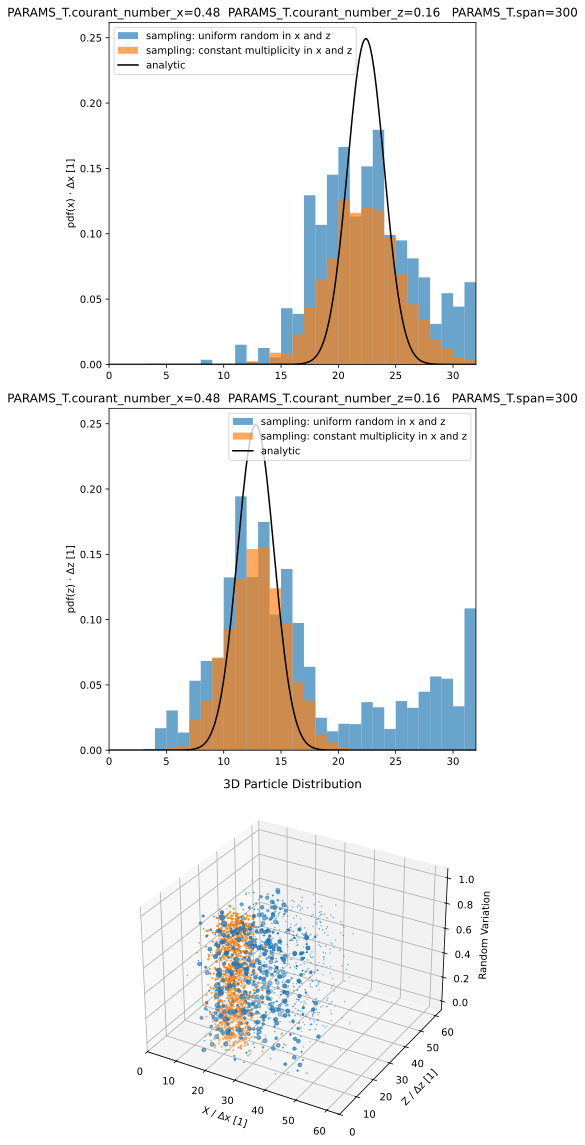

In [238]:
plot(
    particles=PARTICLES,
    params_pxz={"x": PARAMS_X, "p": PARAMS_P, "z": PARAMS_Z},
    rng=RNG,
    shift=(PARAMS_T.wind_x * PARAMS_T.span, PARAMS_T.wind_z * PARAMS_T.span),
    title=f'{PARAMS_T.courant_number_x=:.3g}  {PARAMS_T.courant_number_z=:.3g}   {PARAMS_T.span=}'
)

## Goal and Conclusions
The goal was to add another dimension in the advection simulation and see how the Monte-Carlo advection solver compares against the analytical solution.

The advection of particles along 2 axis' was achieved, with separate wind strengths for either axis, although the comparison between the numerical and analytical solution shows that the error introduced through using a numeric method increases after introducing more dimensions.